In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import pickle


df = pd.read_csv("SupplyChainEmissionFactorsforUSIndustriesCommodities2015_Summary.csv")
df = df.drop(columns=["Unnamed: 7"], errors="ignore")
df = df.drop(index=0)
df["Supply Chain Emission Factors without Margins"] = pd.to_numeric(
    df["Supply Chain Emission Factors without Margins"], errors="coerce"
)
df_cleaned = df.dropna(subset=["Supply Chain Emission Factors without Margins"])


df_cleaned.to_csv("preprocessed_data.csv", index=False)


features = [col for col in df_cleaned.columns if col.startswith("DQ ")]
X = df_cleaned[features].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df_cleaned["Supply Chain Emission Factors without Margins"], errors='coerce')

X = X.dropna()
y = y.loc[X.index]

model = LinearRegression()
model.fit(X, y)


with open("forecasting_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("preprocessed_data.csv and forecasting_model.pkl have been created successfully.")

preprocessed_data.csv and forecasting_model.pkl have been created successfully.


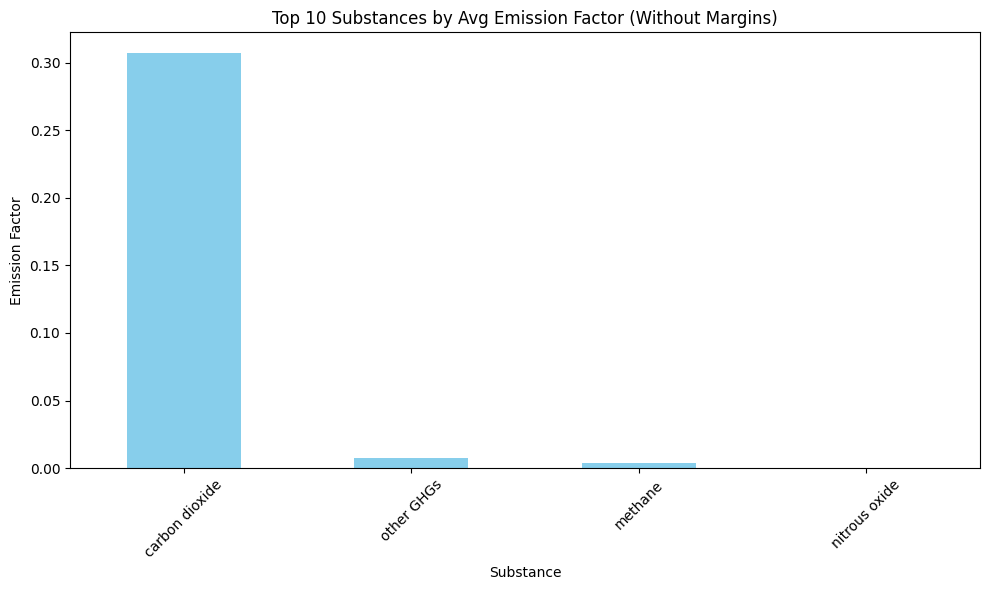

In [2]:
import matplotlib.pyplot as plt

substance_avg = (
    df_cleaned.groupby("Substance")["Supply Chain Emission Factors without Margins"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
substance_avg.plot(kind="bar", color="skyblue")
plt.title("Top 10 Substances by Avg Emission Factor (Without Margins)")
plt.ylabel("Emission Factor")
plt.xlabel("Substance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

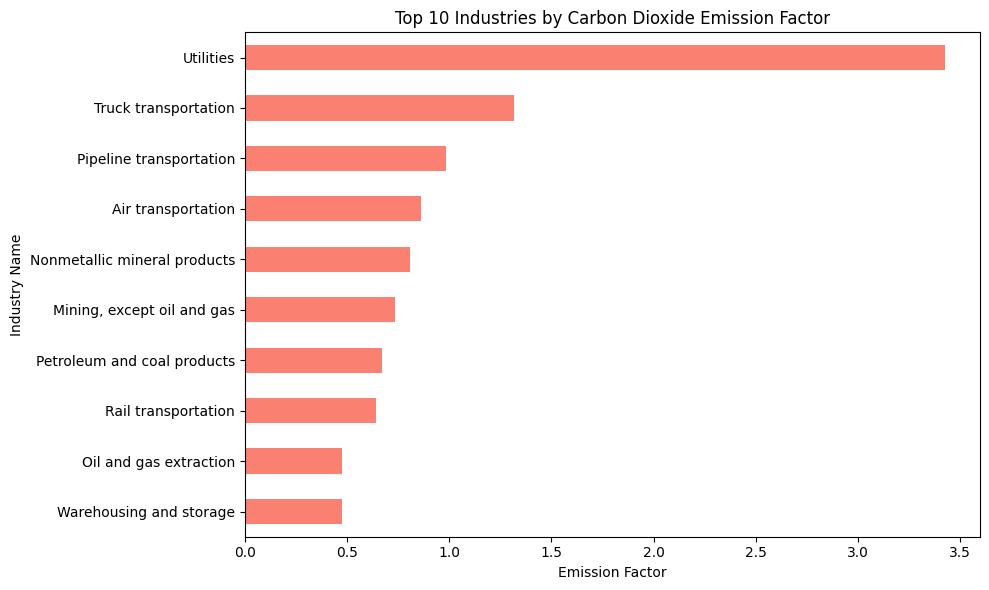

In [3]:

co2_df = df_cleaned[df_cleaned["Substance"] == "carbon dioxide"]

top_co2_industries = (
    co2_df.groupby("Industry Name")["Supply Chain Emission Factors without Margins"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
top_co2_industries.plot(kind="barh", color="salmon")
plt.title("Top 10 Industries by Carbon Dioxide Emission Factor")
plt.xlabel("Emission Factor")
plt.ylabel("Industry Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


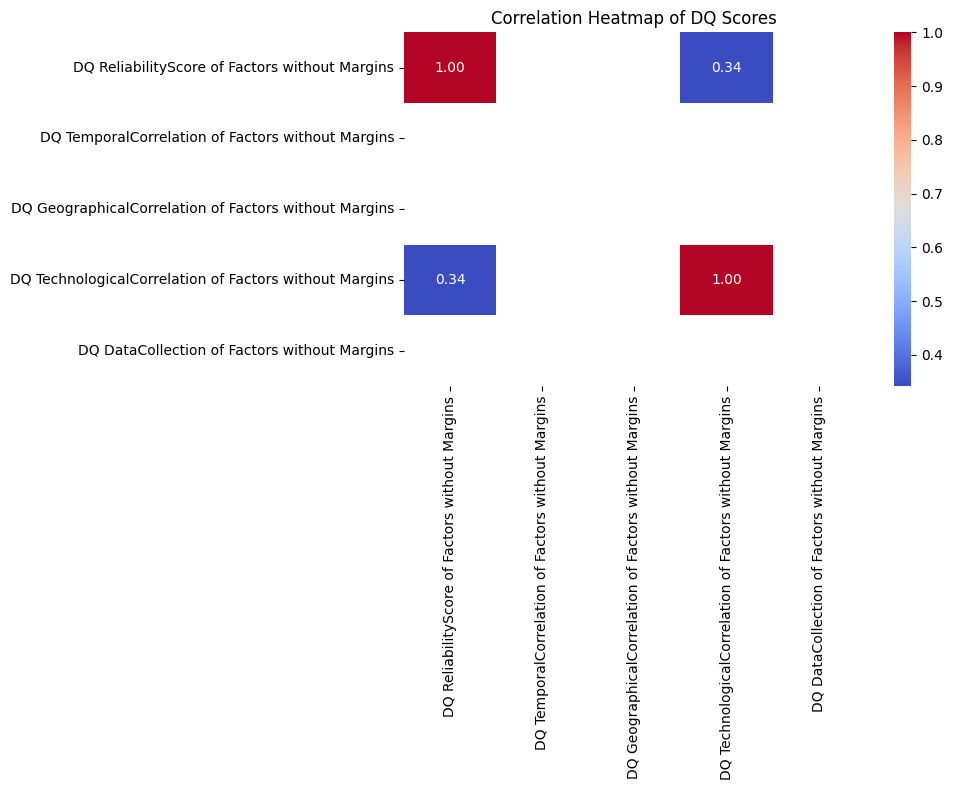

In [4]:
import seaborn as sns

dq_columns = [col for col in df_cleaned.columns if col.startswith("DQ ")]
dq_corr = df_cleaned[dq_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(dq_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of DQ Scores")
plt.tight_layout()
plt.show()


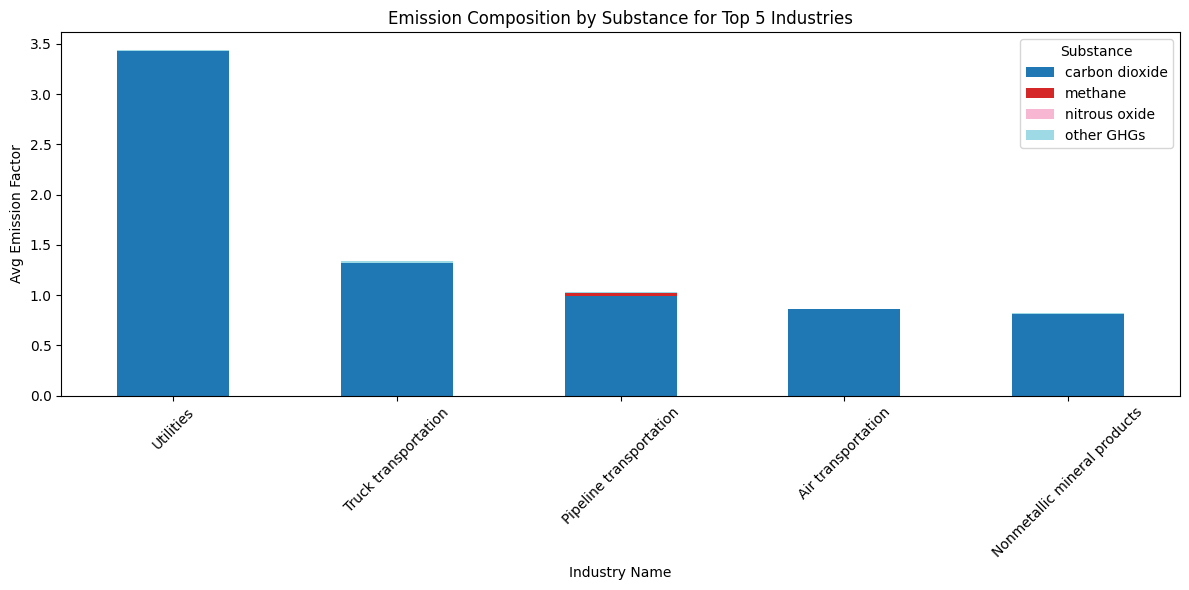

In [5]:

pivot_df = df_cleaned.pivot_table(
    index="Industry Name",
    columns="Substance",
    values="Supply Chain Emission Factors without Margins",
    aggfunc="mean"
).fillna(0)


top5_industries = pivot_df.sum(axis=1).sort_values(ascending=False).head(5).index


stacked_data = pivot_df.loc[top5_industries]


stacked_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Emission Composition by Substance for Top 5 Industries")
plt.ylabel("Avg Emission Factor")
plt.xticks(rotation=45)
plt.legend(title="Substance")
plt.tight_layout()
plt.show()


/tmp/ipython-input-773357575.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


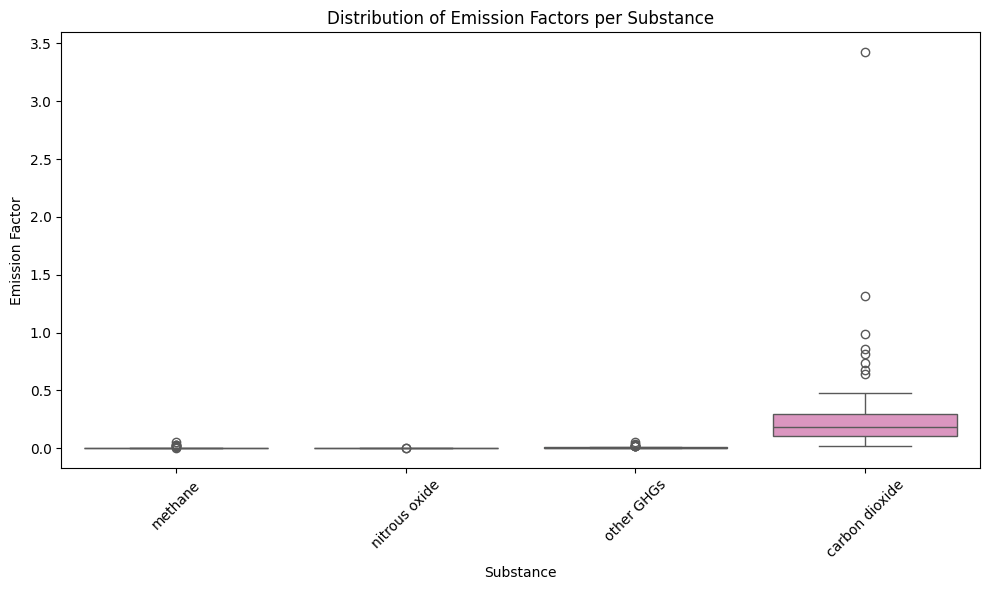

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_cleaned,
    x="Substance",
    y="Supply Chain Emission Factors without Margins",
    palette="Set2"
)
plt.title("Distribution of Emission Factors per Substance")
plt.ylabel("Emission Factor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


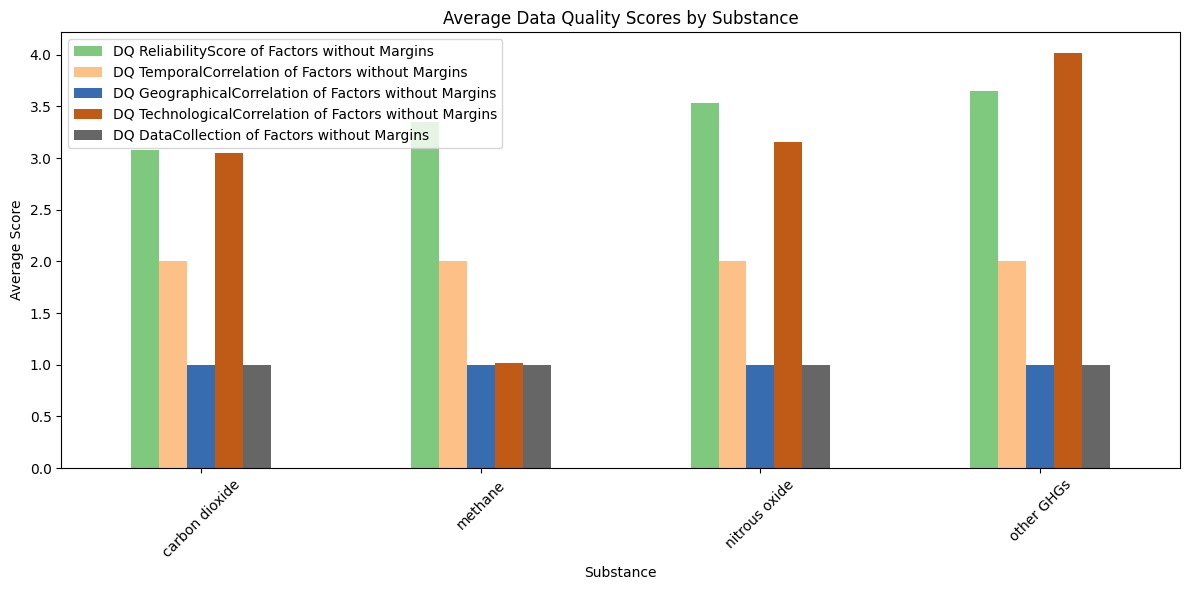

In [24]:

dq_columns = [col for col in df_cleaned.columns if col.startswith("DQ ")]
dq_avg_by_substance = df_cleaned.groupby("Substance")[dq_columns].mean()


dq_avg_by_substance.head(4).plot(kind="bar", figsize=(12, 6), colormap="Accent")
plt.title("Average Data Quality Scores by Substance")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


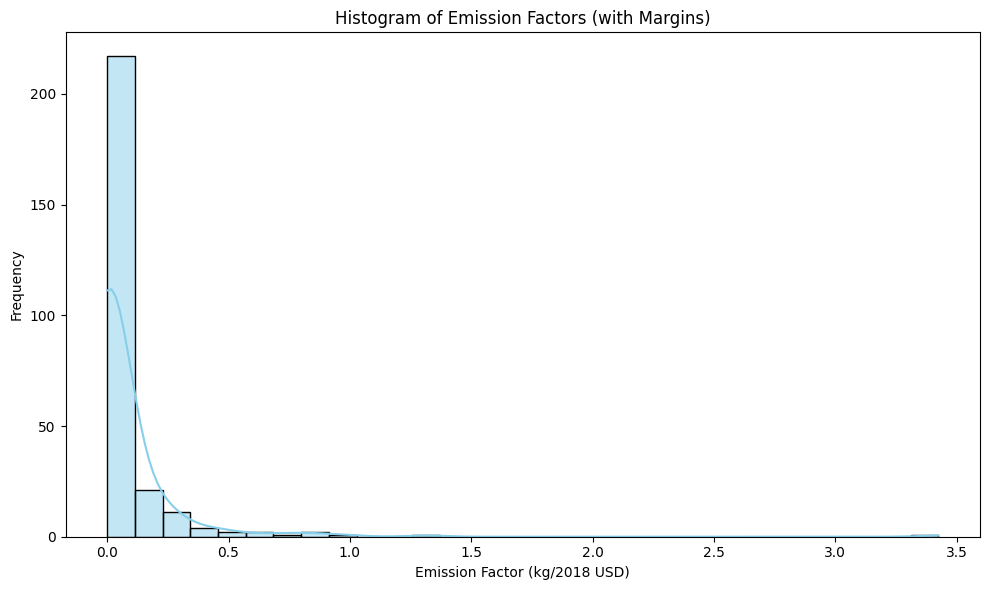

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Supply Chain Emission Factors with Margins'].dropna(), kde=True, bins=30, color='skyblue')
plt.title('Histogram of Emission Factors (with Margins)')
plt.xlabel('Emission Factor (kg/2018 USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {'model': model, 'predictions': preds}


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

for name, res in results.items():
    preds = res['predictions']
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"\n{name}:\n  RMSE: {rmse:.2f}\n  MAE: {mae:.2f}\n  R²: {r2:.4f}")


Linear Regression:
  RMSE: 0.47
  MAE: 0.14
  R²: -0.0062

Decision Tree:
  RMSE: 0.47
  MAE: 0.14
  R²: 0.0084

Random Forest:
  RMSE: 0.47
  MAE: 0.14
  R²: 0.0112


<Figure size 1000x600 with 0 Axes>

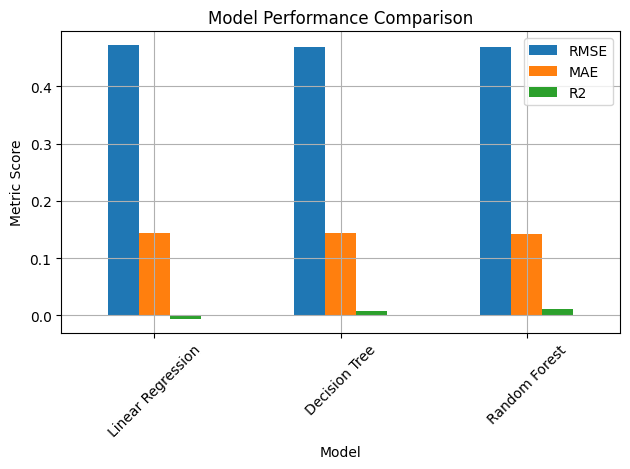

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
metrics = {'Model': [], 'RMSE': [], 'MAE': [], 'R2': []}
for name, res in results.items():
    preds = res['predictions']
    metrics['Model'].append(name)
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, preds)))
    metrics['MAE'].append(mean_absolute_error(y_test, preds))
    metrics['R2'].append(r2_score(y_test, preds))

metrics_df = pd.DataFrame(metrics)

# Bar plot
plt.figure(figsize=(10, 6))
metrics_df.set_index('Model')[['RMSE', 'MAE', 'R2']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Metric Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

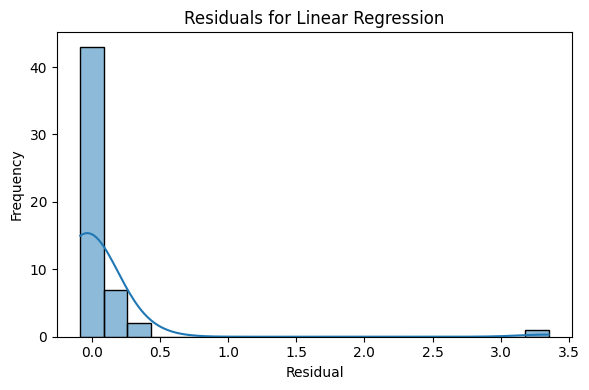

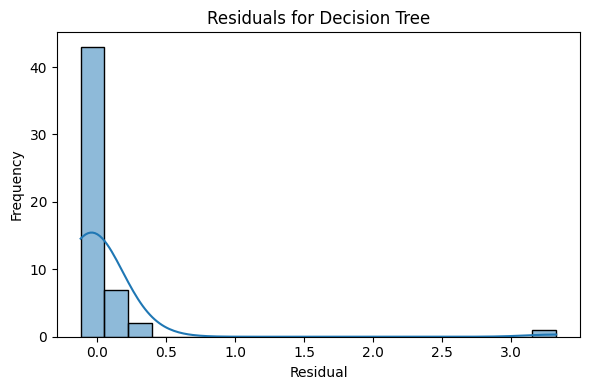

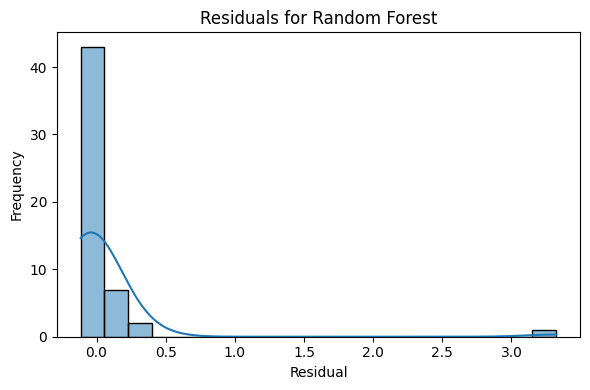

In [15]:
for name, res in results.items():
    residuals = y_test - res['predictions']
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=20)
    plt.title(f'Residuals for {name}')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


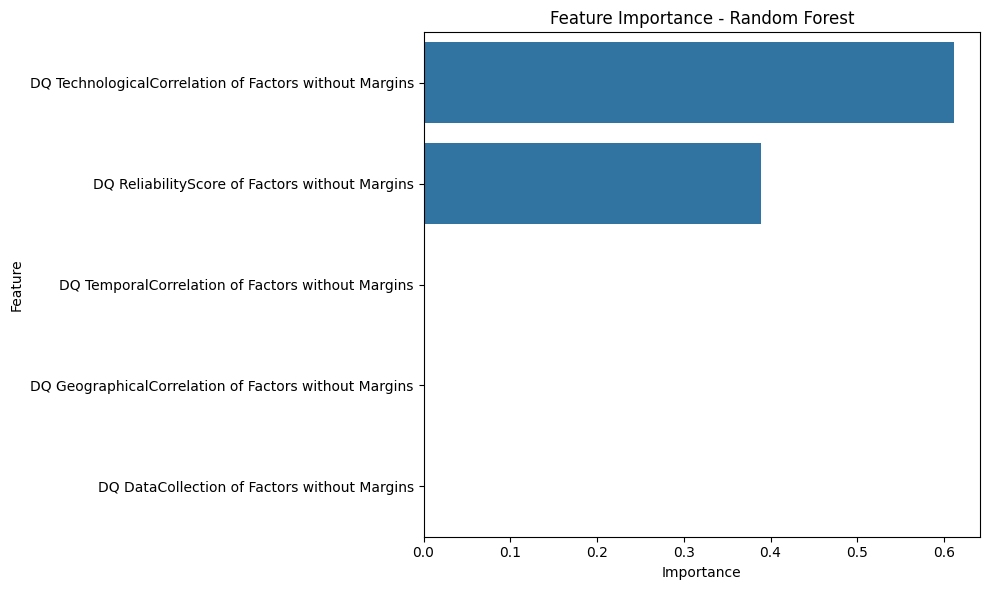

In [17]:
importances = models['Random Forest'].feature_importances_
feature_names = X.columns

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()